### Mean-Variance Potfolio Optimization with Elastic Net Penalty


In [70]:
import pylops 
import numpy as np
import pandas as pd
import scipy.optimize

import matplotlib.pyplot as plt

###  Returns below
- Note log returns have caused some issues numerically within optimiztion

In [99]:
equity_data=pd.read_csv('equity_data_2021.csv')
equity_data.index=equity_data['Date']
equity_data=equity_data.drop(columns=['Date'])

returns=equity_data/equity_data.shift(1)
returns=returns.fillna(0)
returns=returns.iloc[1:]
frac=0.75
cutoff=np.floor(frac*len(returns.index)).astype(int)

returns_train=returns.iloc[:cutoff]
returns_test=returns.iloc[cutoff:]

returns_train

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.999958,1.006013,1.002211,1.015649,1.017300,1.004615,1.015550,0.992267,1.018796,1.010863,...,1.018709,0.993721,0.989166,0.993307,1.012193,0.999142,1.019863,1.006932,0.998817,1.004598
2018-01-04,1.013071,1.004685,0.998303,0.994297,1.017516,1.011841,0.990048,1.016843,1.012042,1.009552,...,1.010151,1.007813,1.005415,0.992209,1.006676,1.010180,1.019760,0.998559,1.004147,1.005964
2018-01-05,1.007792,1.012864,1.002890,1.017408,1.015408,1.008249,1.026446,0.993325,1.011571,0.999409,...,1.006413,1.009277,1.006671,0.992997,0.998126,1.005828,1.015576,1.009941,1.000393,1.011444
2018-01-08,0.996758,1.004763,0.997118,0.983978,1.027086,1.007991,1.003917,0.997760,0.998381,0.996957,...,0.994613,1.000000,0.986686,1.007480,1.003611,1.001690,1.009951,1.001905,0.995086,1.011996
2018-01-09,1.006214,0.999210,1.001700,1.007538,1.009432,1.003335,0.993396,1.003243,1.008971,1.006953,...,1.002774,0.995971,1.006778,0.988333,1.000288,0.997349,1.030643,0.983917,1.023509,1.011719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,1.003046,1.006714,1.008376,0.999806,0.997895,0.999456,1.008314,1.001824,1.005937,1.007820,...,1.014319,1.011956,0.992108,1.004976,1.005214,1.007023,0.992495,1.001812,0.996093,1.005443
2020-12-28,1.001089,1.002523,0.994832,1.001840,1.031311,1.009250,1.005167,1.005259,0.998180,1.000283,...,0.981729,0.996944,1.009441,1.010676,1.001197,1.020829,1.015124,0.997588,1.000461,1.010391
2020-12-29,0.995078,0.983639,1.005010,1.012083,1.025630,0.992606,0.999344,0.994970,1.006333,0.990148,...,0.999279,0.983056,0.989954,1.001531,0.991432,0.996994,0.988107,1.023910,0.986393,1.004495


### Computation of Naive mean and covariance estimation from sample

In [100]:
returns_mean=returns_train.mean()
returns_cov=np.cov(returns_train.T)

Text(0, 0.5, 'Freq')

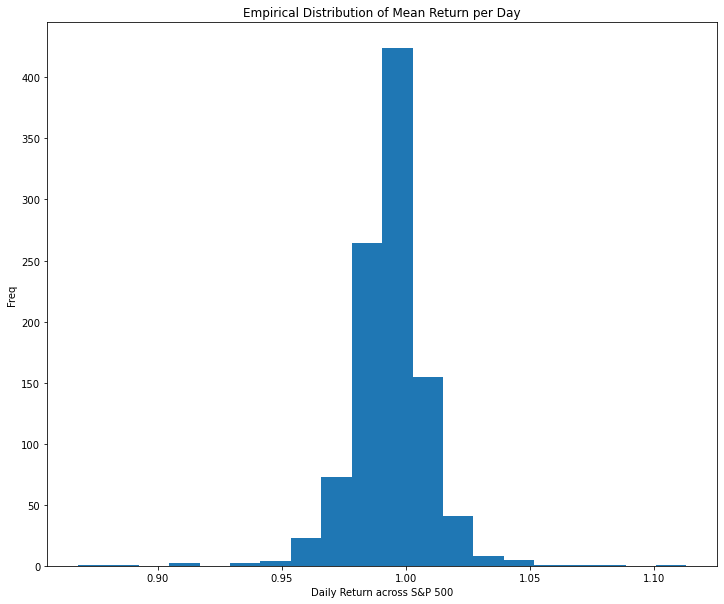

In [101]:
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.hist(returns.mean(axis=1),bins=20)
plt.title("Empirical Distribution of Mean Return per Day")
plt.xlabel("Daily Return across S&P 500")
plt.ylabel("Freq")

Text(0.5, 1.0, 'Singular Values of Covariance Matrix')

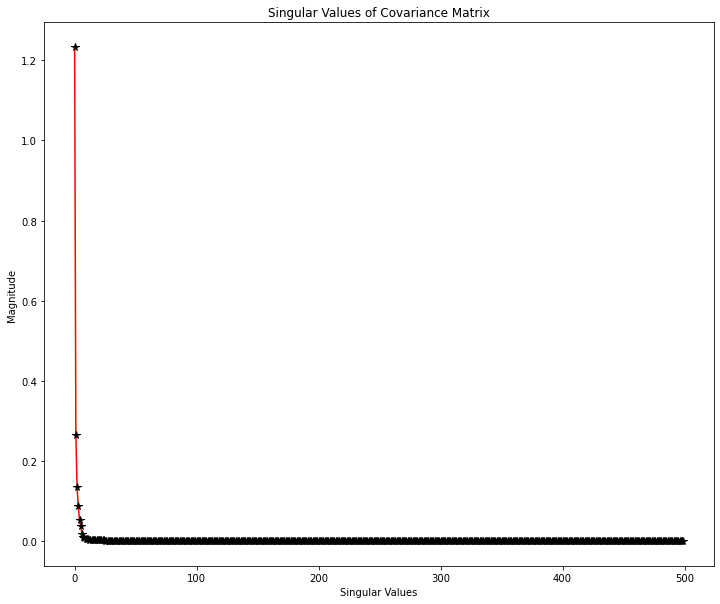

In [102]:
u,s,v=np.linalg.svd(returns_cov)
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.plot(s,marker='*',color='red',markersize=7.5,mfc='black',mec='black')
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title("Singular Values of Covariance Matrix")

### Regularized Covariance and Mean Estimators

### Application of Sparse Solver Split Bregman Operator

Utilizes nested optimization routine where
- Inner Optimization is unconstrained QP problem involving L2 penalty
- Applies shrinkage (L1) penalty within outer loop


In [103]:
def qp(cov,mean,w,d,b,beta,lambda1,tol,maxiter):
    """ Inner optimization problem using unconstrained optimization 
    """
    
    x0=w # initial guess is previous result
    def objective_val(w,cov,mean,d,b,beta,lambda1):
        """ MPT objective
        """
        
        obj=np.dot(np.dot(w,cov),w)-np.dot(w,mean)
        
        l2_pen=np.sum((d-beta*w-b)**2)

        return obj+lambda1*l2_pen/2

    res=scipy.optimize.minimize(objective_val,x0=w,args=(returns_cov,returns_mean,d,b,beta,lambda1),method='CG',options={'maxiter':100},tol=1e-5)
    
    w=res.x
    
    return w

def shrinkage(w,d,b,lambda1,beta):
    """ Shrinkage operator; second optimization routine
    """
    
    x=beta*w+b
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  # elementwise max
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,lambda1,beta=None,tol=1e-10,maxiter=100):
    """ Split Bregman Optimization Routine
    """

    error=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.zeros(n)
    d=np.zeros(n)
    
    
    i=0
    while error>tol:
        if i>maxiter:
            print("MaxIter Achieved")
            break
            
        
        if i%25==0 and i>0:
            print(f"{i}-th iteration with error of {error}")
        
        w_old=w
        w=qp(cov,mean,w_old,d,b,beta,lambda1,tol,maxiter)
        error=np.sum((w-w_old)**2)
        
        d=shrinkage(w,d,b,lambda1,beta)
        b=b+w-d       
        i+=1
    
    unit_w=w/np.linalg.norm(w,ord=1)
    print(f"Terminated in {i} iterations of error {error}")
    return np.round(unit_w,4),error



### Numerical Results

- 10x magnitude on lambda1 param

In [104]:
lambda1=0.1
w1,error1=split_bregman(returns_mean,returns_cov,lambda1=lambda1,tol=1e-8,maxiter=250)

25-th iteration with error of 0.0034670133809293433
50-th iteration with error of 0.00022730861807208468
75-th iteration with error of 8.644423695344062e-05
100-th iteration with error of 3.252269940923347e-05
125-th iteration with error of 1.8225687192700275e-05
150-th iteration with error of 1.0590740728730398e-05
175-th iteration with error of 4.9170596849862595e-06
200-th iteration with error of 8.581238580875467e-06
225-th iteration with error of 5.19257847146041e-06
250-th iteration with error of 5.282783816396423e-06
MaxIter Achieved
Terminated in 251 iterations of error 5.799122316972397e-06


Text(0, 0.5, 'Weight Allocation')

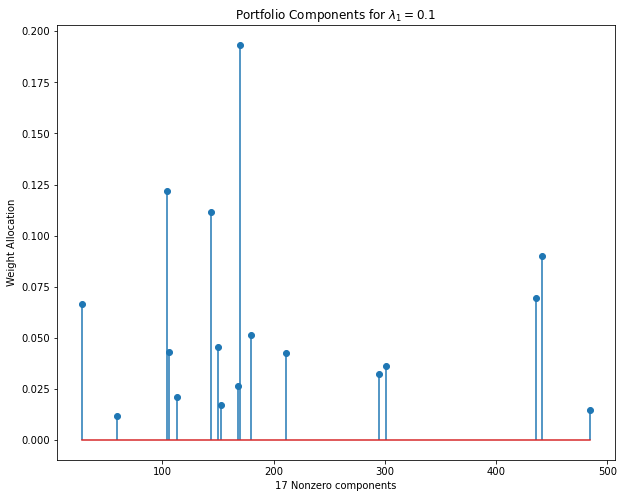

In [105]:
nonzero_w1=np.where(w1>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=0.1$")
ax.stem(nonzero_w1,w1[nonzero_w1])
plt.xlabel(f"{len(nonzero_w1)} Nonzero components")
plt.ylabel("Weight Allocation")

In [106]:
lambda1=1
w2,error2=split_bregman(returns_mean,returns_cov,lambda1=lambda1,tol=1e-8,maxiter=250)

25-th iteration with error of 7.034655360812407e-05
50-th iteration with error of 3.478677173486365e-05
75-th iteration with error of 2.156198201018354e-05
100-th iteration with error of 1.4361485631152369e-05
125-th iteration with error of 9.619300429273981e-06
150-th iteration with error of 7.251533287965573e-06
175-th iteration with error of 5.209217786574563e-06
200-th iteration with error of 4.092914584367945e-06
225-th iteration with error of 3.1328339980644742e-06
250-th iteration with error of 2.5514396341041675e-06
MaxIter Achieved
Terminated in 251 iterations of error 2.5360755507923152e-06


Text(0, 0.5, 'Weight Allocation')

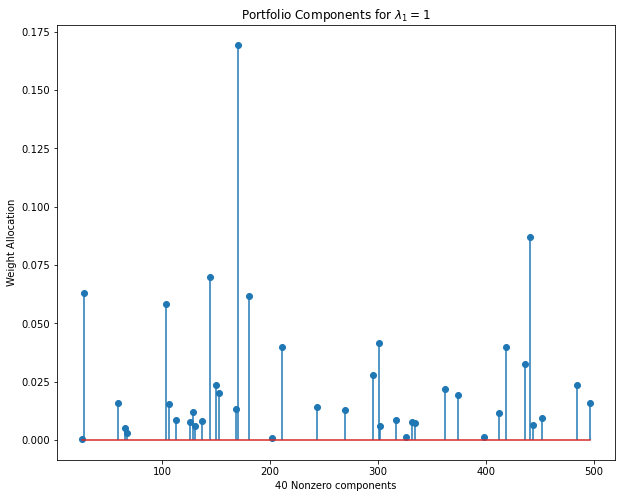

In [107]:
nonzero_w2=np.where(w2>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=1$")
ax.stem(nonzero_w2,w2[nonzero_w2])
plt.xlabel(f"{len(nonzero_w2)} Nonzero components")
plt.ylabel("Weight Allocation")


In [108]:
lambda1=10
w3,error3=split_bregman(returns_mean,returns_cov,lambda1=lambda1,tol=1e-8,maxiter=250)

25-th iteration with error of 2.6592130113223813e-06
50-th iteration with error of 1.851847502717013e-06
75-th iteration with error of 1.4295020944210675e-06
100-th iteration with error of 1.1744470625135935e-06
125-th iteration with error of 1.0057504126737316e-06
150-th iteration with error of 8.820993413697778e-07
175-th iteration with error of 7.821284083494921e-07
200-th iteration with error of 7.113695351953362e-07
225-th iteration with error of 6.417650220053872e-07
250-th iteration with error of 5.92658960221922e-07
MaxIter Achieved
Terminated in 251 iterations of error 5.915484967803212e-07


Text(0, 0.5, 'Weight Allocation')

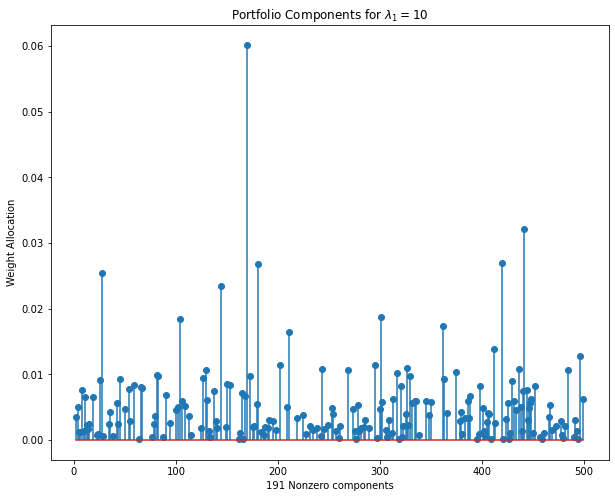

In [109]:
nonzero_w3=np.where(w3>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10$")
ax.stem(nonzero_w3,w3[nonzero_w3])
plt.xlabel(f"{len(nonzero_w3)} Nonzero components")
plt.ylabel("Weight Allocation")

### Grid Search Lambda Values 

In [110]:
def grid_search(params,returns_mean,returns_cov,tol=1e-8,maxiter=250):
    results={}
    for i in params:
        w,error=split_bregman(returns_mean,returns_cov,lambda1=i,tol=1e-8,maxiter=250)
        results[i]=(w,error)
    sorted_dict=sorted(results.items(), key=lambda x:x[1][1])
    return sorted_dict

lambda_grid=np.logspace(-1,4,8)

sorted_dict=grid_search(lambda_grid,returns_mean,returns_cov)

25-th iteration with error of 0.0034670133809293433
50-th iteration with error of 0.00022730861807208468
75-th iteration with error of 8.644423695344062e-05
100-th iteration with error of 3.252269940923347e-05
125-th iteration with error of 1.8225687192700275e-05
150-th iteration with error of 1.0590740728730398e-05
175-th iteration with error of 4.9170596849862595e-06
200-th iteration with error of 8.581238580875467e-06
225-th iteration with error of 5.19257847146041e-06
250-th iteration with error of 5.282783816396423e-06
MaxIter Achieved
Terminated in 251 iterations of error 5.799122316972397e-06
25-th iteration with error of 0.00016823067121391272
50-th iteration with error of 6.485215640902962e-05
75-th iteration with error of 3.1067527564140146e-05
100-th iteration with error of 1.773906335679289e-05
125-th iteration with error of 1.072834897515605e-05
150-th iteration with error of 6.587894390518159e-06
175-th iteration with error of 5.110521388389978e-06
200-th iteration with e

Text(0, 0.5, 'Weight Allocation')

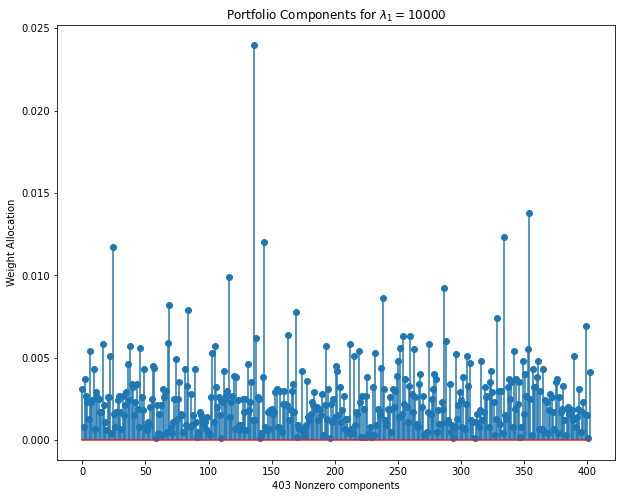

In [114]:
wi=sorted_dict[0][1][0]
nonzero_wi=np.where(abs(wi)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10000$")
ax.stem(wi[nonzero_wi])
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")

In [116]:
print(f"Largest Component is {max(wi[nonzero_wi])}")
print(f"Smallest Component is {min(wi[nonzero_wi])}")

Largest Component is 0.024
Smallest Component is 0.0001


### Sharpe Ratio Performance 

In [112]:
returns_test

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.983294,0.983583,0.996529,0.983761,0.976959,0.981815,0.968228,0.989288,0.970447,0.958910,...,0.966869,0.964197,0.947443,0.984851,0.979369,0.974761,0.983868,0.993965,0.988260,0.988459
2021-01-05,0.998313,1.006491,1.012373,1.010341,1.018533,1.005693,1.008788,1.019451,1.000721,0.997218,...,0.991654,1.002895,1.030776,0.990253,0.998796,1.000095,1.006453,1.017302,1.015840,1.006969
2021-01-06,1.015212,1.034457,0.997918,0.991362,0.996931,1.010934,0.970338,1.040519,0.960098,0.996498,...,1.008416,1.005850,1.005990,1.022147,1.042181,1.005481,1.037444,1.028496,1.112359,1.014691
2021-01-07,0.974338,1.012291,1.009707,1.010703,1.006063,1.009435,1.018977,0.991115,1.024512,1.005658,...,1.007609,1.007151,0.990077,0.980439,1.045389,0.992388,1.036168,0.994072,1.030509,0.999103
2021-01-08,0.981735,0.988210,1.002785,1.005248,1.001545,1.003647,1.018178,1.002670,1.015406,1.013029,...,0.992156,0.991675,0.993440,1.009208,0.989860,1.014678,0.991127,0.997803,0.974595,1.006647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.009887,1.023318,1.016528,1.009918,1.015956,1.029803,1.004450,1.009627,1.014150,1.017727,...,1.010995,1.026123,0.985374,1.003153,1.006723,1.019728,1.041071,1.006457,1.010423,1.016494
2021-12-28,1.005320,1.009917,0.993002,0.999851,0.998910,0.999856,1.018640,1.013017,0.985598,0.999107,...,0.998578,1.009145,0.987212,1.011973,1.010398,0.999783,0.985140,1.003130,1.001587,0.990832
2021-12-29,1.004335,1.003156,1.005126,1.007218,1.012310,1.000361,1.007350,1.001195,0.999877,1.007884,...,0.998785,1.008678,0.982882,1.005028,0.998661,1.004928,1.006362,1.000156,1.005387,1.011382
